In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import scipy
from collections import Counter
import copy
%matplotlib inline

In [3]:
base_time = 1474275600
class BInfo:
    def __init__(self,params):
        self.id = params[4]
        self.num_operators = params[0]
        self.arrival_time = np.array(params[1]) - base_time
        self.start_time = np.array(params[2]) - base_time
        self.end_time = np.array(params[3]) - base_time
    def __str__(self):
        line = 'bank : ' + str(self.id) + '\n'
        line += str(self.num_operators) + '\n'
        line += str(self.arrival_time[0]) + ' '
        line += str(self.start_time[0]) + ' '
        line += str(self.end_time[0])
        return line

In [4]:
def read_from_files(files):
    data = []
    k = 0
    for fpath in files:
        params = []
        with open(fpath) as f_in:
            i = -1
            for line in f_in:
#                 print(line)
                i += 1
                if i == 1:
                    continue
                s = line.split()
                
                if i == 0:
                    params.append(int(s[-1]))
                    for j in range(3):
                        params.append([])
                else :
                    for j in range(3):
                        params[j + 1].append(int(s[j]))
        params.append(k)
        data.append(BInfo(params))            
        k += 1
    return data

In [5]:
files = ['data/office_' + str(i) for i in range(5)]
data = read_from_files(files)

## 1

Первая серия моментов времени образует пуассоновский процесс $N_t = sup\{n: S_n \leq t\}$, так как по условию промежутки времени $\xi_i$ между приходом следующим $i$-м клиентном распределены экспоненциально ($\xi_i \sim exp(\lambda)$) и независимы в совокупности.

In [6]:
def build_first_plot(info):
    n = len(info.arrival_time)
    plt.figure(figsize=(15,7))
    plt.title('bank ' + str(info.id))
    plt.xlabel('time , sec')
    plt.ylabel('ordinal number')
    for i in range(n):
        x1 = [info.arrival_time[i] , info.start_time[i]]
        x2 = [info.start_time[i] , info.end_time[i]]
        plt.plot(x1,[i,i], color = 'r')
        plt.plot(x2,[i,i], color = 'g')
    plt.show()

def build_poiss_proc_plot(info):
    n = len(info.arrival_time)
    plt.figure(figsize=(15,7))
    plt.grid(True)
    plt.title('bank ' + str(info.id))
    plt.xlabel('t , sec')
    plt.ylabel('N_t')
    X = np.zeros(2*(n+1)) # build T
    Y = np.array([i for i in range(0,2*(n+1))]) // 2 #build N_t
    for j in range(2,2*(n+1)):
        X[j] = info.arrival_time[Y[j] - 1]
    plt.plot(X,Y)
    plt.xlim([0,X[-1] + 10])
    plt.ylim([0,Y[-1]+5])
    plt.show()

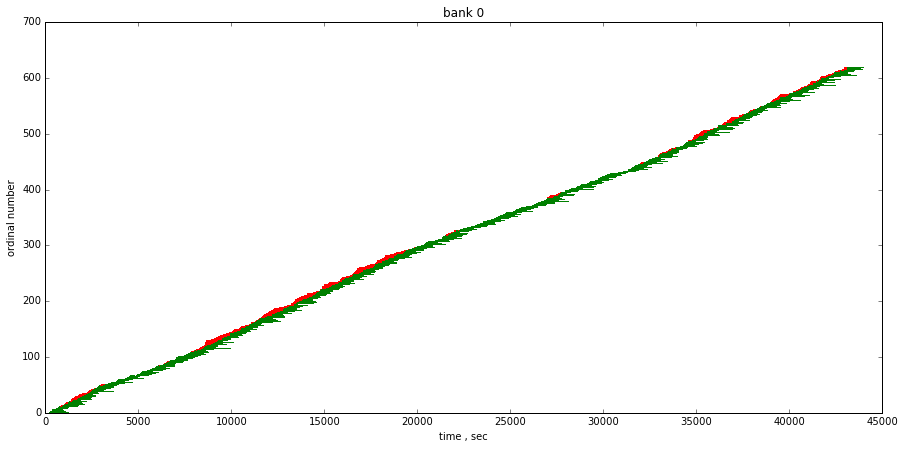

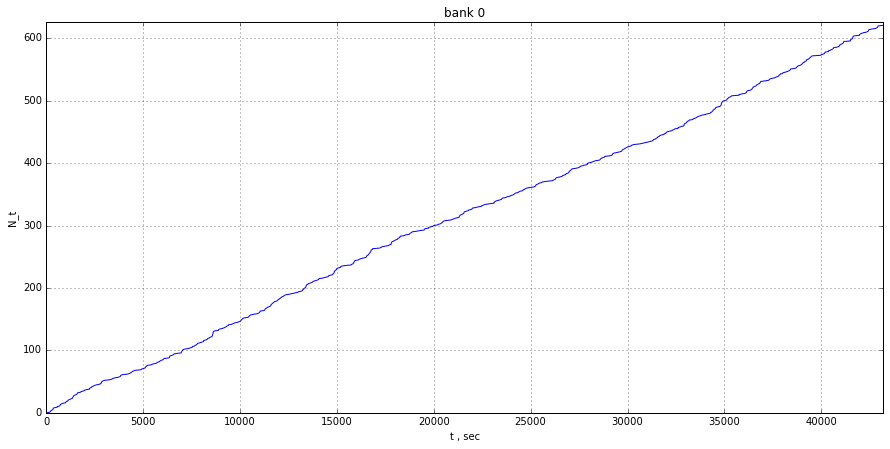

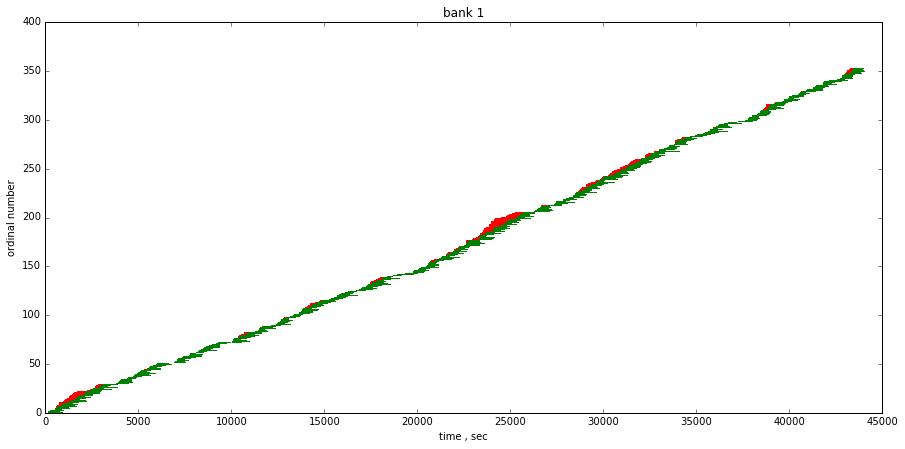

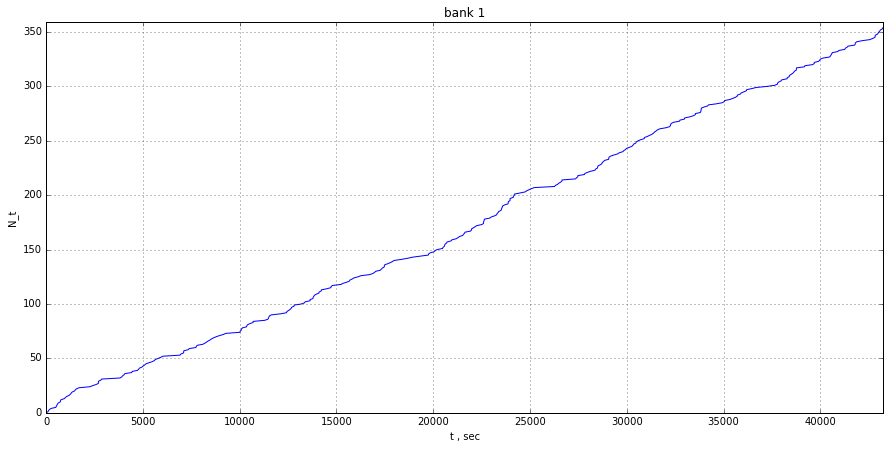

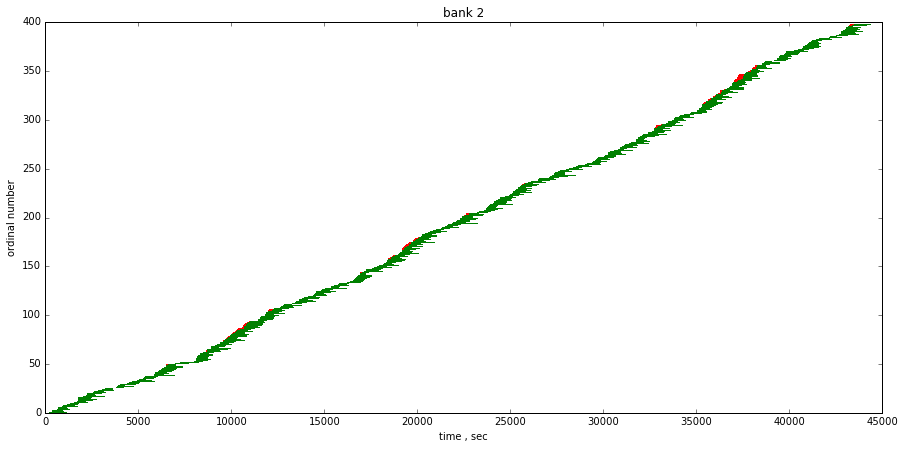

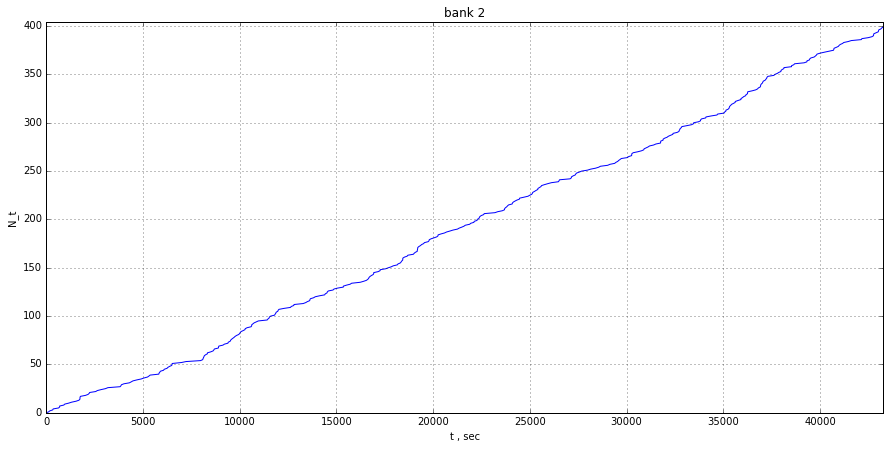

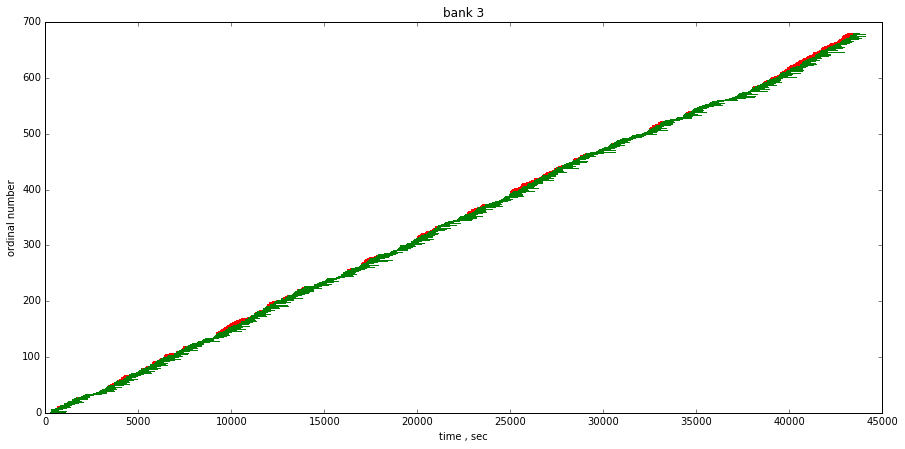

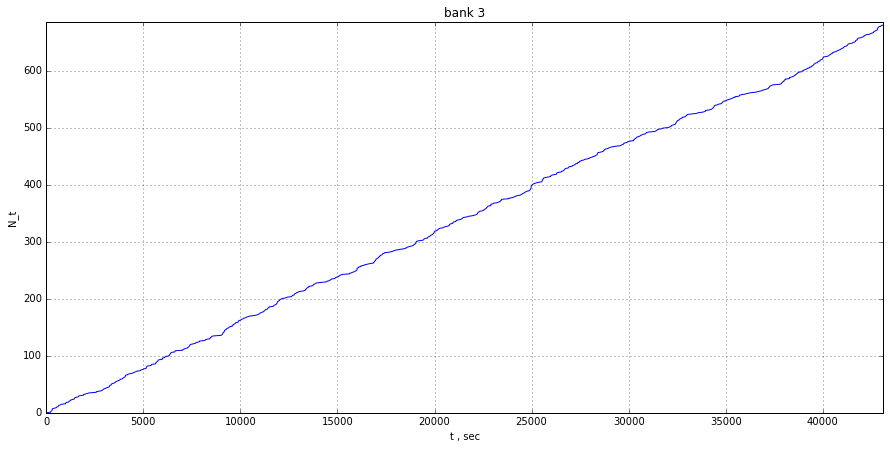

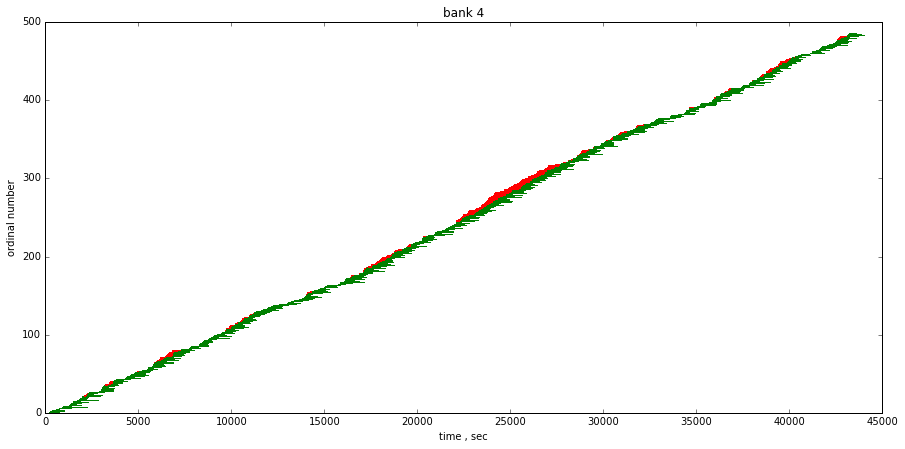

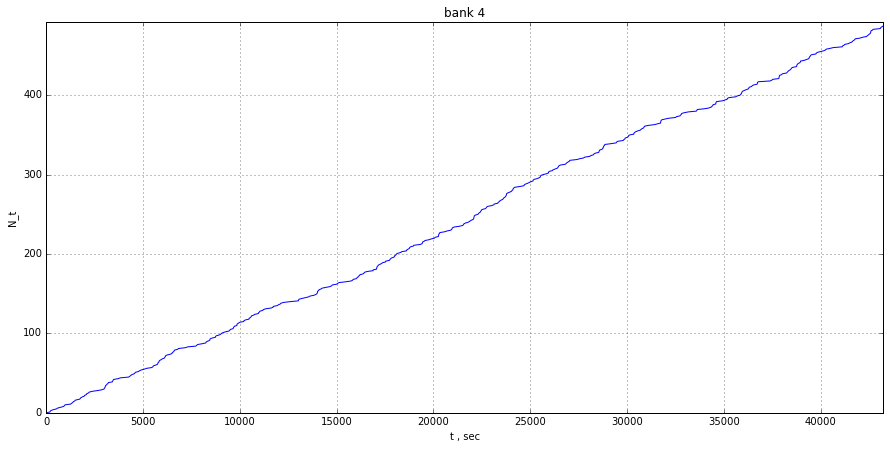

In [7]:
for i in range(5) : 
    build_first_plot(data[i])
    build_poiss_proc_plot(data[i])

Для экспоненциального распределения методом максимального правдоподобия получаем оценку $\hat{\lambda} = \frac{1}{\overline{X}}$, где $X_i = t_i - t_{i-1}$ , $t_i$ - время прихода $i$ - го клиента ($t_0 :=0$)

In [8]:
def get_estimation_exp(info):
    X = np.zeros(len(info.arrival_time))
    for i in range(1,len(info.arrival_time)):
        X[i] = info.arrival_time[i] - info.arrival_time[i-1]
    X[0] = info.arrival_time[0]
    return 1 / np.mean(X)

def get_avg_service_duration(info):
    service_duration = info.end_time - info.start_time
    return np.mean(service_duration)

In [9]:
lmb = []
avg_service_duration = []
for info in data:
    lmb.append(get_estimation_exp(info))
    avg_service_duration.append(get_avg_service_duration(info))
    print(str(info.id) + ': lambda = ' + str(lmb[-1]) +\
          ', avg service duration = ' + str(avg_service_duration[-1]))

0: lambda = 0.014379660075, avg service duration = 625.355877617
1: lambda = 0.00818610674313, avg service duration = 592.474576271
2: lambda = 0.00922436712519, avg service duration = 642.192982456
3: lambda = 0.0158011972713, avg service duration = 599.190895742
4: lambda = 0.0112687137006, avg service duration = 594.63449692


Приблизим распределение времени обслуживания отрицательным биномиальным распределением.

https://ru.wikipedia.org/wiki/Отрицательное_биномиальное_распределение

Оценим параметры методом моментов.

Для построения графиков и использования критерия, разобьем значения на временные отрезки по 60 секунд.

In [121]:
def nbinom_params(X):
    a = np.mean(X)
    d = np.var(X)
    p = a/d
    r = a**2/(d-a)
    return r,p

def build_density_hist(info) :
    service_time = info.end_time - info.start_time
    plt.figure(figsize=(12,5))
    plt.grid(True)
    plt.title('density hist; bank ' + str(info.id))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    
    quant,bins,patches = plt.hist(service_time,
                                  bins=np.arange(0,1600,60),
                                  normed=True,facecolor='b', alpha=0.5)

    #build nbinom plot
    r,p = nbinom_params(service_time)
    rv = sps.nbinom(r,p)
    OX = np.arange(0,1600)
    OY = [rv.pmf(x) for x in OX]
    plt.plot(OX,OY,color='r')
    plt.show()
    
    return r,p,quant * 60 * len(service_time)
    

Построим график частот времени ожидания от величины времени ожидания.

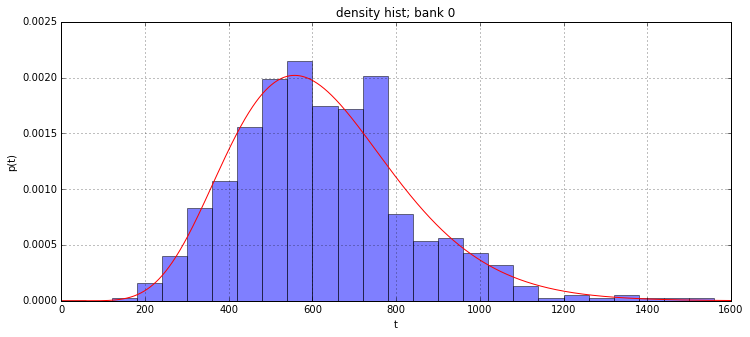

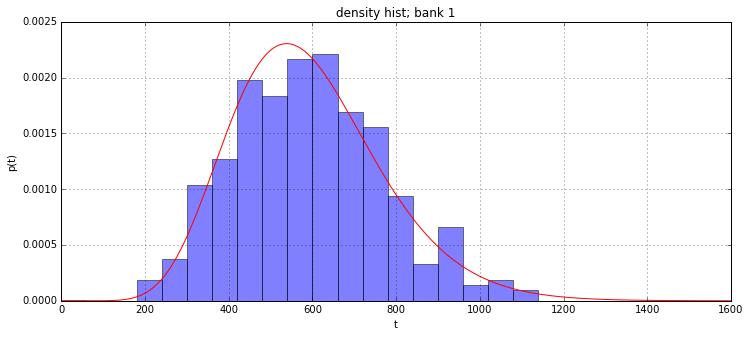

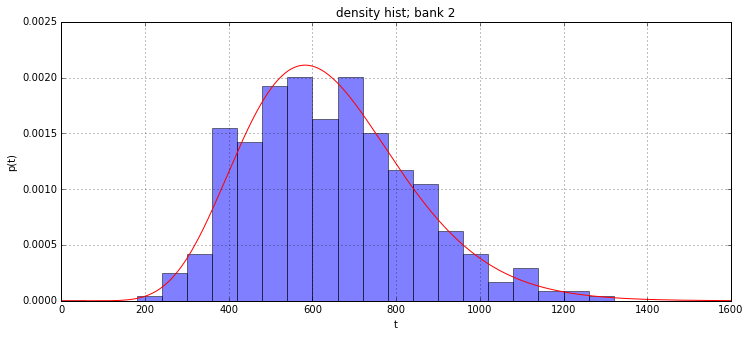

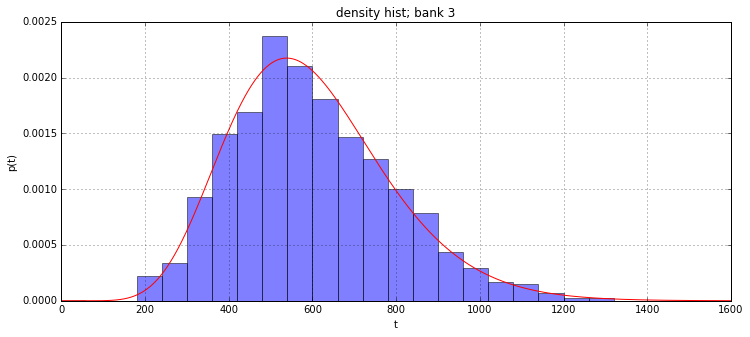

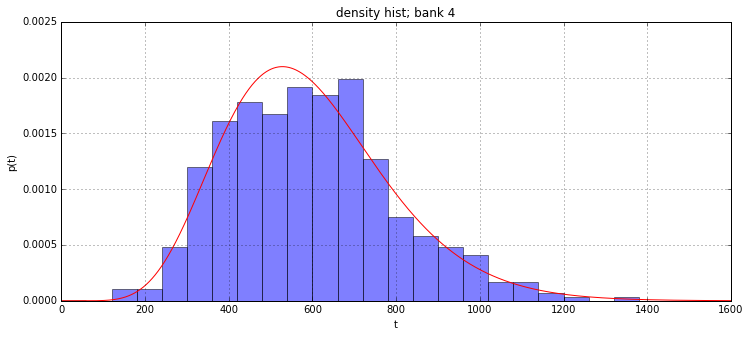

In [122]:
quanted_freq = []
R = [] #nbinom params
P = []
for info in data:
    r, p, q_fr = build_density_hist(info)
    quanted_freq.append(q_fr)
    R.append(r)
    P.append(p)
    

Применим критерий ХИ-квадрат:

In [138]:
def get_chisquare(idx) :
    quant = quanted_freq[idx]
    r = R[idx]
    p = P[idx]
    rv = sps.nbinom(r,p)
    
    n = np.sum(quant)
    OX = np.arange(0,1600,60)
    fexp = [n*(rv.cdf(OX[i]) - rv.cdf(OX[i-1])) for i in range(1,len(OX))]
    print('bank ' + str(idx) + ':')
    val , pval = sps.chisquare(quant, f_exp=fexp)
    print('statistic=' + str(val) +', pvalue=' + str(pval))
    
for i in range(5):
    get_chisquare(i)

bank 0:
statistic=30.6852559967, pvalue=0.19965323541
bank 1:
statistic=16.9449853306, pvalue=0.883779501908
bank 2:
statistic=14.7051593339, pvalue=0.948005496411
bank 3:
statistic=9.95773454388, pvalue=0.996764699988
bank 4:
statistic=17.6051332318, pvalue=0.858686735401


Критерий показал, что наше приближение очень хорошо работает (за исключением, быть может, первого банка) и можно считать, что время распределено по отрицательному биномиальному закону.

# 2

Построим доверительный интервал, уровня доверия $1 - \alpha$:

$P(z_{\frac{\alpha}{2}} \leq N_t \leq z_{1 - \frac{\alpha}{2}}) \geq 1-\alpha$ , где $z_x$ - квантиль уровня $x$ для распределения $Poiss(\lambda t)$

$z_{\frac{\alpha}{2}} - \frac{mt}{t_0} \leq X_t \leq z_{1 - \frac{\alpha}{2}} - \frac{m(t-t_0)}{t_0}$

In [184]:
def get_poiss_confidence_interval(lmb , alpha):
    return sps.poisson.ppf(alpha/2,lmb) , sps.poisson.ppf(1-alpha/2,lmb)

def build_confidence_interval(m , t0, lmb, alpha,T_max):
    L = []
    R = []
    M = []
    OX = np.arange(0,T_max + 1)
    for t in OX:
        l_n,r_n = get_poiss_confidence_interval(lmb=t*lmb,alpha=alpha)
        M.append(l_n)
        L.append(max(l_n - m*t/t0,0))
        R.append(max(r_n - m*(t-t0)/t0,0))
        
    plt.figure(figsize=(15,7))
    plt.grid(True)
    plt.plot(OX,L,'r')
    plt.plot(OX,R,'b')
    plt.fill_between(OX,L,R,alpha=0.3,color='g')
#     plt.plot(OX,M)
#     plt.xlim(500,2000)
#     plt.ylim(0,20)
    
    plt.title('lambda=' + str(lmb) + ' ; m=' + str(m))
    plt.show()


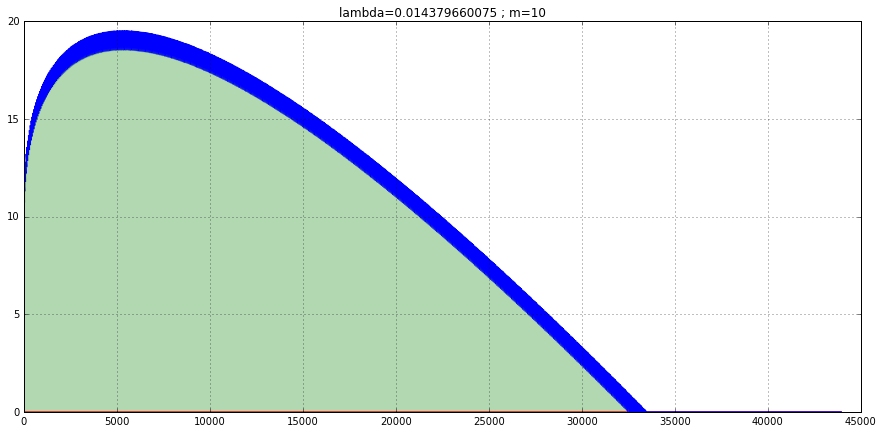

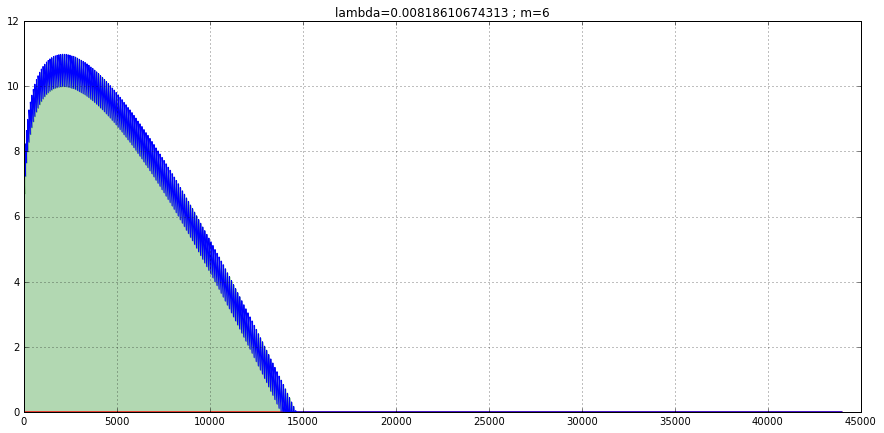

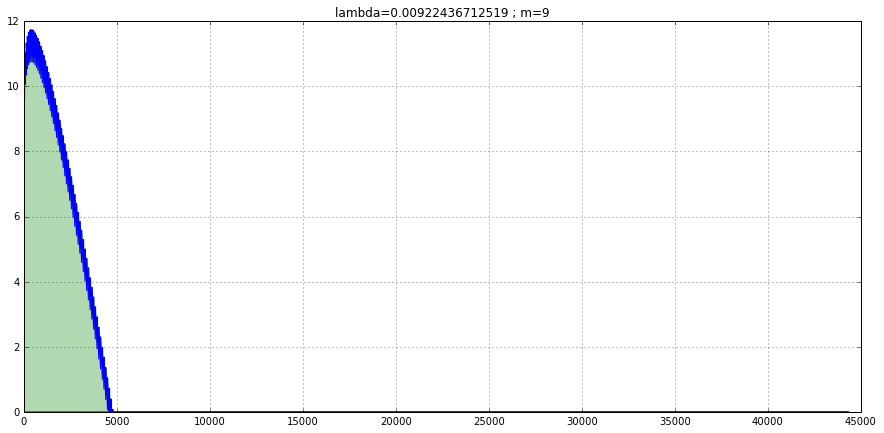

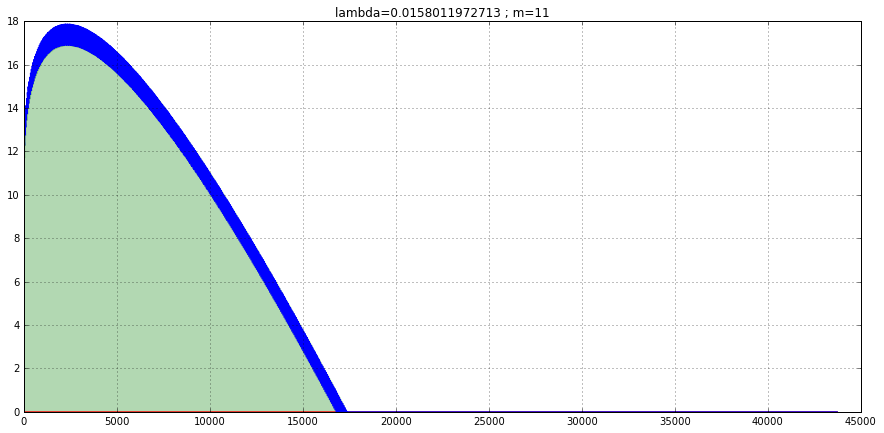

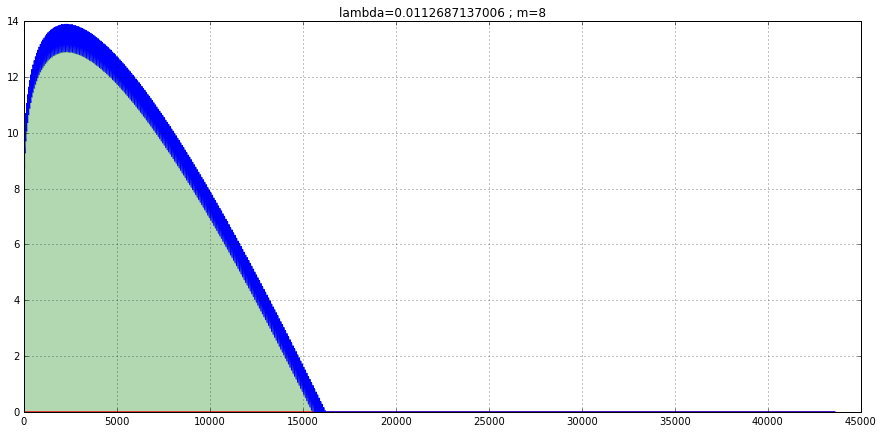

In [185]:
for i in range(5): #len(data)
    build_confidence_interval(m=data[i].num_operators,
                             t0=avg_service_duration[i],
                             lmb=lmb[i],
                             alpha=0.05,
                             T_max = data[i].end_time[-1])

Видим, что при данных $m$ для каждого банка верхняя граница доверительного интервала перестает возрастать с ростом времени и обращается в $0$. Это происходит из-за предположения(используемого в формуле для интервала), что в любой момент времени все операторы заняты работой. Но как видно на графиках из пункта 1, большую часть времени работает меньшее число операторов(т.к. каждый вновь пришедший клиент почти всегда мгновенно получает оператора).

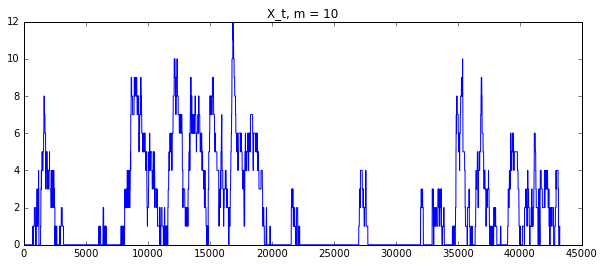

maximum waiting clients = 12.0


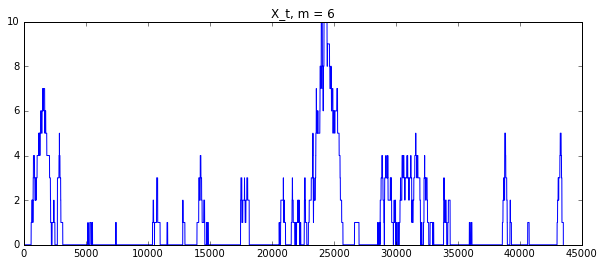

maximum waiting clients = 10.0


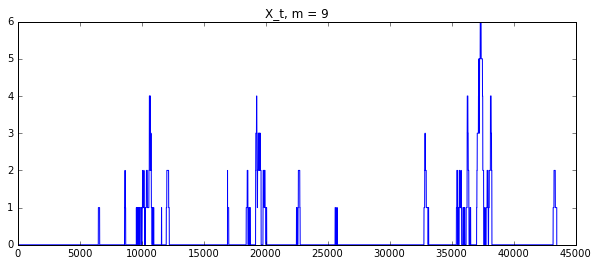

maximum waiting clients = 6.0


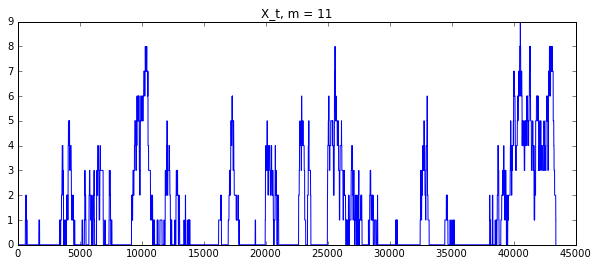

maximum waiting clients = 9.0


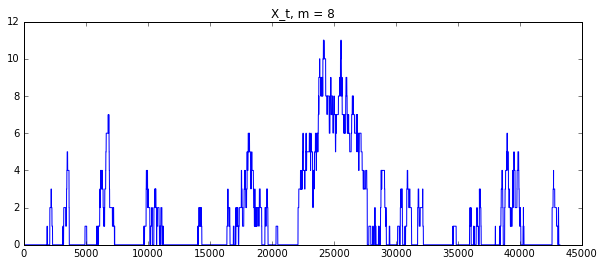

maximum waiting clients = 11.0


In [191]:
def get_x_t(info) :
    OX = np.arange(info.start_time[-1]+1)
    X_t = np.zeros(len(OX))
    cur_wait = 0
    id1 = 0
    id2 = 0
    for t in OX:
        while id1 < len(info.arrival_time) and info.arrival_time[id1] <= t:
            cur_wait +=1
            id1 +=1
        while id2 < len(info.start_time) and info.start_time[id2] <= t:
            cur_wait -=1
            id2 +=1
        X_t[t] = cur_wait
        
    plt.figure(figsize=(10,4))
    plt.title('X_t, m = ' + str(info.num_operators))
    plt.plot(OX,X_t)
    plt.show()
    print('maximum waiting clients = ' + str(np.max(X_t)))

for info in data:
    get_x_t(info)
    